<a href="https://colab.research.google.com/github/hatkaran/Face_Detection/blob/main/Face_Detection_Network_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0

Num GPUs Available:  0


In [ ]:
import pickle
import random
import IPython
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Loading the Pre Processed dataset
IMAGE_A = pd.read_pickle(r'/content/drive/MyDrive/Data of face recog./FIRST_IMAGE.pickle')
IMAGE_B = pd.read_pickle(r'/content/drive/MyDrive/Data of face recog./SECOND_IMAGE.pickle')
labels =  pd.read_pickle(r'/content/drive/MyDrive/Data of face recog./labels.pickle')

In [ ]:
train_image_A = IMAGE_A[:1500]
train_image_B = IMAGE_B[:1500]
test_image_A = IMAGE_A[1500:]
test_image_B = IMAGE_B[1500:]
train_labels = labels[:1500]
test_labels = labels[1500:]

In [ ]:
def model_builder():

    l1_reg = 1e-3

    l2_reg = 1e-3

    dropout = 0.35

    left_input = Input((IMAGE_A.shape[1:]))
    right_input = Input((IMAGE_A.shape[1:]))

    encoding_sequence = Sequential([
                              Conv2D(128,(3,3), input_shape=(80,80,3), activation = 'relu'),
                              Conv2D(128,(3,3), activation = 'relu'),
                              Conv2D(128,(3,3),activation = 'relu'),
                              MaxPooling2D(),
                              Flatten(),
                              Dense(128, activation = 'relu'),
                              Dense(128, activation = 'relu')
                              ])

    encoded_l = encoding_sequence(left_input)
    encoded_r = encoding_sequence(right_input)

    L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    prediction = Dense(128, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(L1_distance)
    prediction = Dropout(dropout)(prediction)
    prediction = Dense(128, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(prediction)
    prediction = Dropout(dropout)(prediction)
    prediction = Dense(96, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(prediction)
    prediction = BatchNormalization()(prediction)
    prediction = Dropout(dropout)(prediction)
    prediction = Dense(96, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(prediction)
    prediction = Dropout(dropout)(prediction)
    prediction = Dense(1, activation = 'sigmoid')(prediction)
    siamese_net = Model(inputs = [left_input,right_input], outputs = prediction)
    siamese_net.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics= [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
    return siamese_net

In [ ]:
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

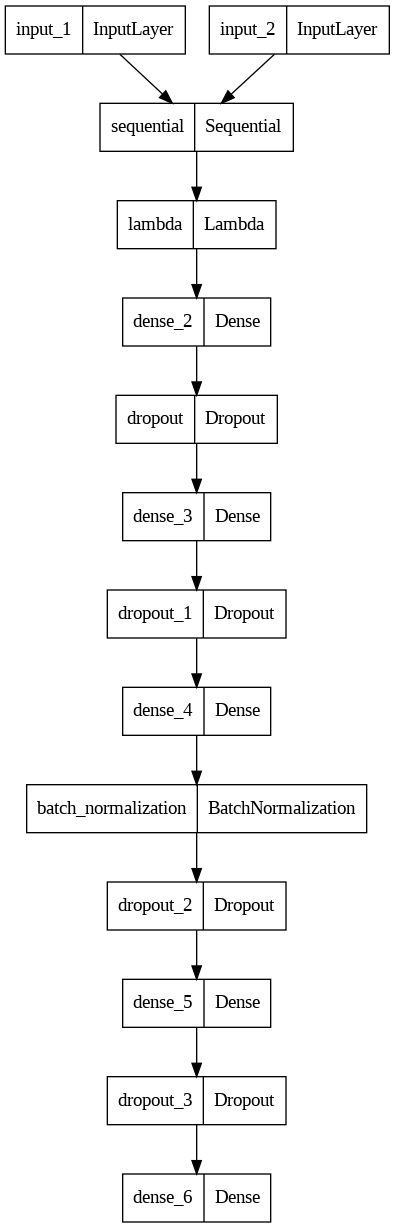

In [ ]:
siamese_net = model_builder()
tf.keras.utils.plot_model(
    siamese_net, to_file='siamese_net.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 128)          22745088    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 128)          0           ['sequential[0][0]',         

In [ ]:
print(len(train_image_A), len(train_image_B), len(train_labels))
print(len(test_image_A), len(test_image_B), len(test_labels))

1500 1500 1500
206 206 206


In [ ]:
epochs_to_wait_for_improve = 10
n_epochs = 10
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint('siamese_net'+'.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = siamese_net.fit([train_image_A,train_image_B],train_labels , validation_data = ([test_image_A,test_image_B], test_labels),
            epochs=n_epochs, callbacks=[early_stopping_callback, checkpoint_callback])

Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 5.0039 - precision: 0.6140 - recall: 0.6841 - accuracy: 0.6300 
Epoch 1: val_accuracy improved from -inf to 0.65534, saving model to siamese_net.h5
47/47 [==============================] - 918s 19s/step - loss: 5.0039 - precision: 0.6140 - recall: 0.6841 - accuracy: 0.6300 - val_loss: 4.5994 - val_precision: 0.9762 - val_recall: 0.3694 - val_accuracy: 0.6553
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 4.1844 - precision: 0.6212 - recall: 0.6788 - accuracy: 0.6353 
Epoch 2: val_accuracy did not improve from 0.65534
47/47 [==============================] - 893s 19s/step - loss: 4.1844 - precision: 0.6212 - recall: 0.6788 - accuracy: 0.6353 - val_loss: 3.8163 - val_precision: 0.8800 - val_recall: 0.3964 - val_accuracy: 0.6456
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 3.5943 - precision: 0.6694 - recall: 0.6667 - accuracy: 0.6713 
Epoch 3: val_accuracy did not improve from 

In [ ]:
import os
import shutil

colab_model_path = '/content/siamese_net.h5'  # Path to the saved model in Colab directory
drive_folder_path = '/content/drive/MyDrive/Data of face recog.'  # Destination folder in Google Drive

if not os.path.exists(drive_folder_path):
    os.makedirs(drive_folder_path)

drive_model_path = os.path.join(drive_folder_path, 'siamese_net.h5')  # Destination path in Google Drive
shutil.move(colab_model_path, drive_model_path)


'/content/drive/MyDrive/Data of face recog./siamese_net.h5'

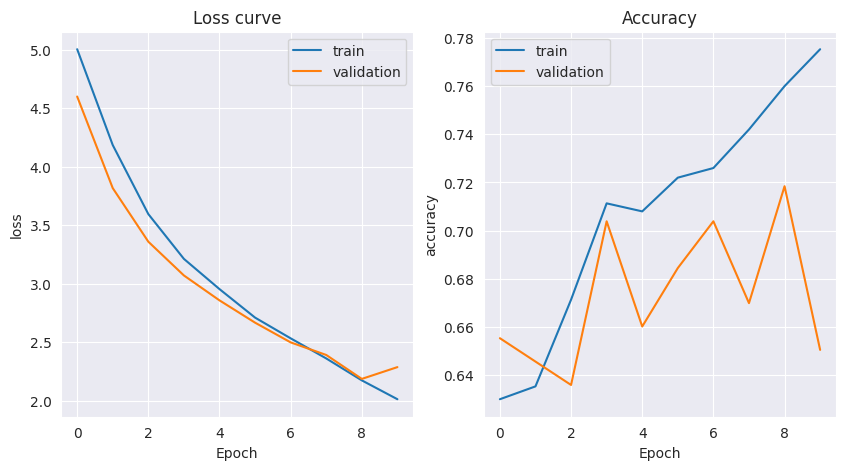

In [ ]:
sns.set_style("darkgrid")
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

#get the entries
xvalues = np.arange(len(train_acc))

#visualise
f, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues,  train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

In [ ]:
eval = siamese_net.evaluate([test_image_A, test_image_B], test_labels)

7/7 [==============================] - 31s 4s/step - loss: 2.2860 - precision: 0.8197 - recall: 0.4505 - accuracy: 0.6505


In [ ]:
def get_predictions(siamese_net, test_data):
    pred = siamese_net.predict(test_data)
    predictions = []
    for i in pred:
        if i>0.5:
            predictions.append(1)
        else :
            predictions.append(0)
    predictions = np.array(predictions)
    return predictions

#Getting Predictions
predictions = get_predictions(siamese_net,[test_image_A, test_image_B])

7/7 [==============================] - 35s 5s/step


<Figure size 640x480 with 0 Axes>

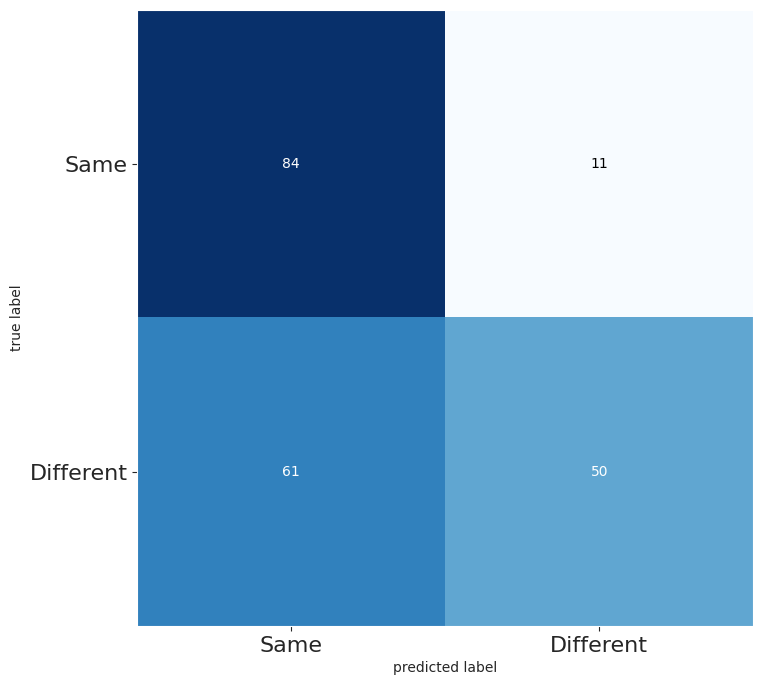

In [ ]:
#Plotting the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Same', 'Different'], fontsize=16)
plt.yticks(range(2), ['Same', 'Different'], fontsize=16)
plt.show()